<a href="https://colab.research.google.com/github/makamnilisha/Amenity-Detection-using-Detectron2/blob/main/Copy_of_effdet_poc_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install albumentations==1.0.0
!pip install effdet==0.4.1
!pip install ensemble-boxes==1.0.6
!pip install fastcore==1.3.20
!pip install pytorch-lightning==2.0.5
!pip install timm==0.4.9
!pip install torch==1.8.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 1.7 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.6 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144552 sha256=a03cd09280b5cf1046fbe60a40ec2e6779a27c7ac8ac6cf6075e2fb6ab12a66f
  Stored in directory: /root/.c

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.2 MB/s eta 0:00:00
  Attempting uninstall: fastcore
    Found existing installation: fastcore 1.5.29
    Uninstalling fastcore-1.5.29:
      Successfully uninstalled fastcore-1.5.29
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.12 requires fastcore<1.6,>=1.5.29, but you have fastcore 1.3.20 which is incompatible.
fastdownload 0.0.7 requires fastcore>=1.3.26, but you have fastcore 1.3.20 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.4/722.4 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.1/346.1 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 0.9.2
    Uninstalling timm-0.9.2:
      Successfully uninstalled timm-0.9.2

In [2]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from pathlib import Path

dataset_path = Path('/content/gdrive/MyDrive/effdet_data/bathtub')
list(dataset_path.iterdir())


[PosixPath('/content/gdrive/MyDrive/effdet_data/bathtub/.DS_Store'),
 PosixPath('/content/gdrive/MyDrive/effdet_data/bathtub/testing_images'),
 PosixPath('/content/gdrive/MyDrive/effdet_data/bathtub/training_images'),
 PosixPath('/content/gdrive/MyDrive/effdet_data/bathtub/training_classes.csv'),
 PosixPath('/content/gdrive/MyDrive/effdet_data/bathtub/testing_classes.csv'),
 PosixPath('/content/gdrive/MyDrive/effdet_data/bathtub/train_solution_bounding_boxes.gsheet'),
 PosixPath('/content/gdrive/MyDrive/effdet_data/bathtub/train_solution_bounding_boxes.csv')]

In [4]:
train_data_path = dataset_path/'training_images/images'

In [5]:
import pandas as pd

df = pd.read_csv(dataset_path/'train_solution_bounding_boxes.csv')

In [6]:
df.head()

,image,width,height,class,xmin,ymin,xmax,ymax
0,04a16a805d8fedd4_jpg.rf.b714fb3cdb17cd6034f824...,512,512,Bathtub,216,80,511,303
1,04a16a805d8fedd4_jpg.rf.b714fb3cdb17cd6034f824...,512,512,Bathtub,1,303,216,473
2,04a16a805d8fedd4_jpg.rf.b714fb3cdb17cd6034f824...,512,512,Bathtub,234,421,495,511
3,38d3e33a4616144c_jpg.rf.a6306723ba1463323e4695...,512,512,Bathtub,344,1,511,104
4,38d3e33a4616144c_jpg.rf.a6306723ba1463323e4695...,512,512,Bathtub,1,425,295,511


In [7]:
#creating a dataset adaptor

import matplotlib.pyplot as plt
from matplotlib import patches

def get_rectangle_edges_from_pascal_bbox(bbox):
    xmin_top_left, ymin_top_left, xmax_bottom_right, ymax_bottom_right = bbox

    bottom_left = (xmin_top_left, ymax_bottom_right)
    width = xmax_bottom_right - xmin_top_left
    height = ymin_top_left - ymax_bottom_right

    return bottom_left, width, height

#create a class the gets rectangle's edges from xml's bbox


def draw_pascal_voc_bboxes(
    plot_ax,
    bboxes,
    get_rectangle_corners_fn= get_rectangle_edges_from_pascal_bbox,
):
    for bbox in bboxes:
        bottom_left, width, height = get_rectangle_corners_fn(bbox)

        rect_1 = patches.Rectangle(
            bottom_left,
            width,
            height,
            linewidth=4,
            edgecolor="black",
            fill=False,
        )
        rect_2 = patches.Rectangle(
            bottom_left,
            width,
            height,
            linewidth=2,
            edgecolor="white",
            fill=False,
        )

        #Add the patch to the Axes
        plot_ax.add_patch(rect_1)
        plot_ax.add_patch(rect_2)

def show_image(
    image, bboxes=None, draw_bboxes_fn=draw_pascal_voc_bboxes, figsize=(10, 10)
):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)

    if bboxes is not None:
        draw_bboxes_fn(ax, bboxes)

    plt.show()


Creates a FireplaceDatasetAdaptor class that converts specific raw dataset format into an image and corresponding annotations.

In [8]:
from pathlib import Path
import PIL

import numpy as np

class FireplaceDatasetAdaptor:
    def __init__(self, images_dir_path, annotations_dataframe):
        self.images_dir_path = Path(images_dir_path)
        self.annotations_df = annotations_dataframe
        self.images = self.annotations_df.image.unique().tolist()

    def __len__(self) -> int:
        return len(self.images) #length of the images data list stored in self.images

    def get_image_and_labels_by_idx(self, index):
        image_name = self.images[index]
        image_name = self.images[index]
        image = PIL.Image.open(self.images_dir_path / image_name)
        pascal_bboxes = self.annotations_df[self.annotations_df.image == image_name][["xmin","ymin","xmax","ymax"]].values

        class_labels = np.ones(len(pascal_bboxes))
        return image, pascal_bboxes, class_labels, index

    def show_image(self, index):
      image, bboxes, class_labels, image_id = self.get_image_and_labels_by_idx(index)
      print(f"image_id: {image_id}")
      show_image(image, bboxes.tolist())
      print(class_labels)

In [9]:
train_ds = FireplaceDatasetAdaptor(train_data_path,df)

image_id: 9


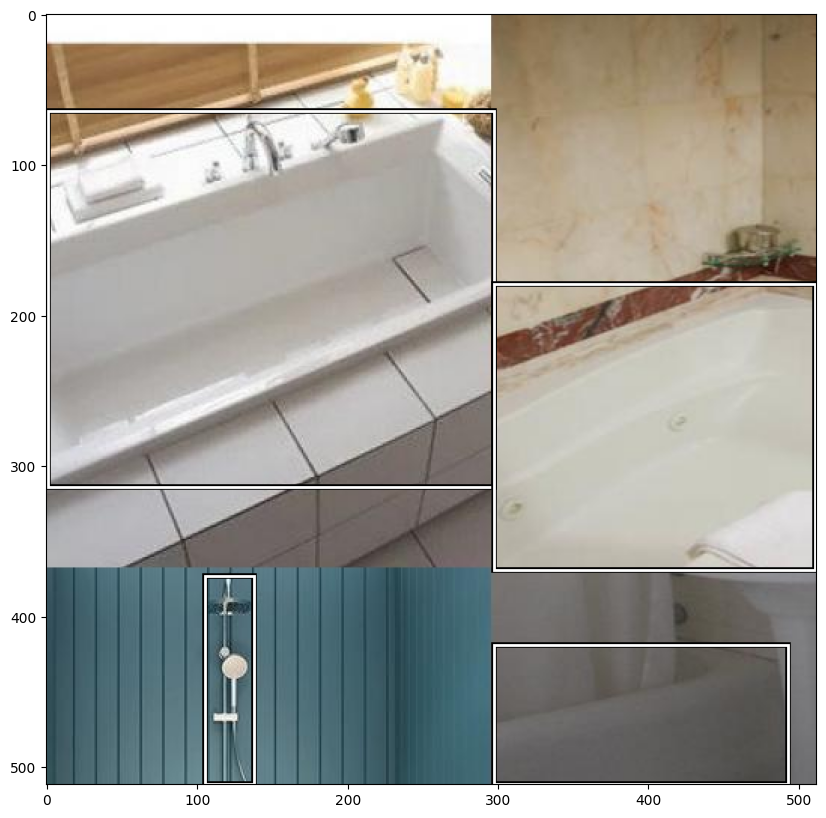

[1. 1. 1. 1.]


In [10]:
train_ds.show_image(9)

image_id: 22


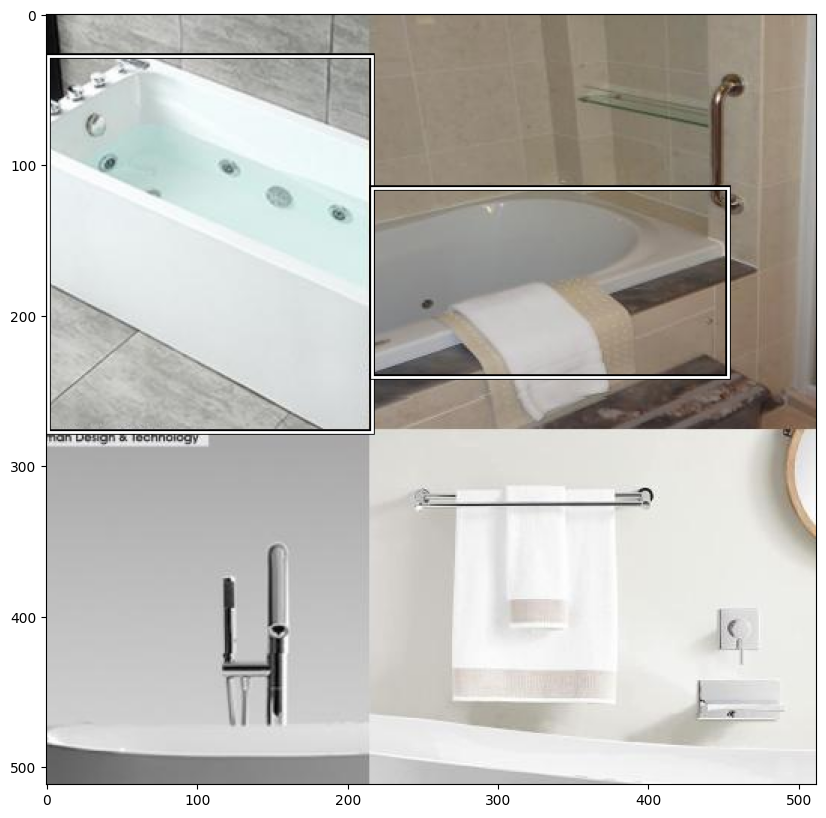

[1. 1.]


In [11]:
train_ds.show_image(22)

In [2]:
train_ds.show_image(82)

NameError: ignored

In [12]:
#Creating the model

from effdet.config.model_config import efficientdet_model_param_dict
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
from effdet.config.model_config import efficientdet_model_param_dict

In [13]:
#view the different configurations of efficientdet

print(f'number of configs: {len(efficientdet_model_param_dict)}')

list(efficientdet_model_param_dict.keys())[::3]

number of configs: 47


['efficientdet_d0',
 'efficientdet_d3',
 'efficientdetv2_dt',
 'cspresdet50',
 'cspdarkdet53',
 'mixdet_l',
 'mobiledetv3_large',
 'efficientdet_q2',
 'efficientdet_em',
 'tf_efficientdet_d1',
 'tf_efficientdet_d4',
 'tf_efficientdet_d7',
 'tf_efficientdet_d1_ap',
 'tf_efficientdet_d4_ap',
 'tf_efficientdet_lite1',
 'tf_efficientdet_lite3x']

Some of these implementations (i.e. efficientdet_d5) have been trained by Ross in PyTorch, whereas any implementation prefixed by ‘tf_’ uses the official pretrained weights. As the initial models were trained in TensorFlow, to use these weights in PyTorch, certain modifications have been made (such as implementing ‘same’ padding) which means that these models may be slower during training and inference.

In addition to the provided configs, we can also use any model from timm as our EfficientDet backbone. Here, let’s try using one of the new EfficientNetv2 models as the backbone. Similarly to before, we can list these models using timm:

In [14]:
import timm

In [15]:
timm.list_models('tf_efficientnetv2_*')

['tf_efficientnetv2_b0',
 'tf_efficientnetv2_b1',
 'tf_efficientnetv2_b2',
 'tf_efficientnetv2_b3',
 'tf_efficientnetv2_l',
 'tf_efficientnetv2_l_in21ft1k',
 'tf_efficientnetv2_l_in21k',
 'tf_efficientnetv2_m',
 'tf_efficientnetv2_m_in21ft1k',
 'tf_efficientnetv2_m_in21k',
 'tf_efficientnetv2_s',
 'tf_efficientnetv2_s_in21ft1k',
 'tf_efficientnetv2_s_in21k']

To use one of these models, we first must register it as an EfficientDet config by adding a dictionary to the **efficientdet_model_param_dict**. Let’s create a function
that does this for us, and then creates the EfficientDet
model using the machinery from effdet:

In [16]:
#the following function creates a dictionary called efficientdet_model_param_dict in the efficientdet config file to use one of the backbones mentioned above

def create_model(num_classes=4, image_size=512, architecture="tf_efficientnetv2_l"):
    efficientdet_model_param_dict['tf_efficientnetv2_l'] = dict(
        name='tf_efficientnetv2_l',
        backbone_name='tf_efficientnetv2_l',
        backbone_args=dict(drop_path_rate=0.2),
        num_classes=num_classes,
        url='', )

    config = get_efficientdet_config(architecture)
    config.update({'num_classes': num_classes})
    config.update({'image_size': (image_size, image_size)})

    print(config)

    net = EfficientDet(config, pretrained_backbone=True)
    net.class_net = HeadNet(
        config,
        num_outputs=config.num_classes,
    )
    return DetBenchTrain(net, config)

*Note that, when altering this, you must also alter the default transfroms which are used by the model, by passing new functions as parameters.*

##Define the efficientDet Dataset- check it for custom
Albumentations lib - used for data augmentations
normalize, resize and convert it into a tensor
add a horizontal flip while training.
We have to pass the bbox as well to the transforms because the albumentations library also applies to the transformations to the labels.

In [17]:
from torch.utils.data import Dataset

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


def get_train_transforms(target_img_size=512):
    return A.Compose(
        [
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            # A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2(p=1),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )


def get_valid_transforms(target_img_size=512):
    return A.Compose(
        [
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            # A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2(p=1),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )
#efficientdet requires the bounding boxes in YXYX format.
class EfficientDetDataset(Dataset):
    def __init__(
        self, dataset_adaptor, transforms=get_valid_transforms()
    ):
        self.ds = dataset_adaptor
        self.transforms = transforms

    def __getitem__(self, index):
        (
            image,
            pascal_bboxes,
            class_labels,
            image_id,
        ) = self.ds.get_image_and_labels_by_idx(index)

        sample = {
            "image": np.array(image, dtype=np.float32),
            "bboxes": pascal_bboxes,
            "labels": class_labels,
        }

        sample = self.transforms(**sample)
        sample["bboxes"] = np.array(sample["bboxes"])
        image = sample["image"]
        pascal_bboxes = sample["bboxes"]
        labels = sample["labels"]

        _, new_h, new_w = image.shape
        sample["bboxes"][:, [0, 1, 2, 3]] = sample["bboxes"][
            :, [1, 0, 3, 2]
        ]  # convert to yxyx

        target = {
            "bboxes": torch.as_tensor(sample["bboxes"], dtype=torch.float32),
            "labels": torch.as_tensor(labels),
            "image_id": torch.tensor([image_id]),
            "img_size": (new_h, new_w),
            "img_scale": torch.tensor([1.0]),
        }

        return image, target, image_id

    def __len__(self):
        return len(self.ds)

##Creating a Data module
While we could now use this dataset to create a standard PyTorch DataLoader, PyTorch-lightning provides a DataModule class, which we can use to group all our data-related components. The interface is quite intuitive, and we can implement as follows:

In [18]:
!pip install --upgrade pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.0.5
    Uninstalling pytorch-lightning-2.0.5:
      Successfully uninstalled pytorch-lightning-2.0.5


In [19]:
import pytorch_lightning as pl
print(pl.__version__)

2.0.6


In [20]:
from pytorch_lightning import LightningDataModule
from torch.utils.data import DataLoader

class EfficientDetDataModule(LightningDataModule):

    def __init__(self,
                train_dataset_adaptor,
                validation_dataset_adaptor,
                train_transforms=get_train_transforms(target_img_size=512),
                valid_transforms=get_valid_transforms(target_img_size=512),
                num_workers=4,
                batch_size=8):

        self.train_ds = train_dataset_adaptor
        self.valid_ds = validation_dataset_adaptor
        self.train_tfms = train_transforms
        self.valid_tfms = valid_transforms
        self.num_workers = num_workers
        self.batch_size = batch_size
        super().__init__()

    def train_dataset(self) -> EfficientDetDataset:
        return EfficientDetDataset(
            dataset_adaptor=self.train_ds, transforms=self.train_tfms
        )

    def train_dataloader(self) -> DataLoader:
        train_dataset = self.train_dataset()
        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            drop_last=True,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
        )

        return train_loader

    def val_dataset(self) -> EfficientDetDataset:
        return EfficientDetDataset(
            dataset_adaptor=self.valid_ds, transforms=self.valid_tfms
        )

    def val_dataloader(self) -> DataLoader:
        valid_dataset = self.val_dataset()
        valid_loader = torch.utils.data.DataLoader(
            valid_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            pin_memory=True,
            drop_last=True,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
        )

        return valid_loader

    @staticmethod
    def collate_fn(batch):
        images, targets, image_ids = tuple(zip(*batch))
        images = torch.stack(images)
        images = images.float()

        boxes = [target["bboxes"].float() for target in targets]
        labels = [target["labels"].float() for target in targets]
        img_size = torch.tensor([target["img_size"] for target in targets]).float()
        img_scale = torch.tensor([target["img_scale"] for target in targets]).float()

        annotations = {
            "bbox": boxes,
            "cls": labels,
            "img_size": img_size,
            "img_scale": img_scale,
        }

        return images, annotations, targets, image_ids

##Define the training Loop
OK, still with me? We’re almost there! In PyTorch-lightning, we tie t**he model, training loop, and optimizer together in a LightningModule**. So instead of having to define our own loops to iterate over each DataLoader, we can do the following:

In [21]:
from numbers import Number
from typing import List
from functools import singledispatch
import torch
import numpy as np
import torch

from fastcore.dispatch import typedispatch
from pytorch_lightning import LightningModule


from ensemble_boxes import ensemble_boxes_wbf


def run_wbf(predictions, image_size=512, iou_thr=0.44, skip_box_thr=0.43, weights=None):
    bboxes = []
    confidences = []
    class_labels = []

    for prediction in predictions:
        boxes = [(prediction["boxes"] / image_size).tolist()]
        scores = [prediction["scores"].tolist()]
        labels = [prediction["classes"].tolist()]

        boxes, scores, labels = ensemble_boxes_wbf.weighted_boxes_fusion(
            boxes,
            scores,
            labels,
            weights=weights,
            iou_thr=iou_thr,
            skip_box_thr=skip_box_thr,
        )
        boxes = boxes * (image_size - 1)
        bboxes.append(boxes.tolist())
        confidences.append(scores.tolist())
        class_labels.append(labels.tolist())

    return bboxes, confidences, class_labels


class EfficientDetModel(LightningModule):
    def __init__(
        self,
        num_classes=4,
        img_size=512,
        prediction_confidence_threshold=0.2,
        learning_rate=0.0002,
        wbf_iou_threshold=0.44,
        inference_transforms=get_valid_transforms(target_img_size=512),
        model_architecture='tf_efficientnetv2_l',
    ):
        super().__init__()
        self.img_size = img_size
        self.model = create_model(
            num_classes, img_size, architecture=model_architecture
        )
        self.prediction_confidence_threshold = prediction_confidence_threshold
        self.lr = learning_rate
        self.wbf_iou_threshold = wbf_iou_threshold
        self.inference_tfms = inference_transforms

    def forward(self, images, targets):
        # Move input tensor to the appropriate device manually
        images = images.to(self.device)
        targets = targets.to(self.device)
        return self.model(images, targets)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.lr)


    def training_step(self, batch, batch_idx):
        images, annotations, _, image_ids = batch

        losses = self.model(images, annotations)

        logging_losses = {
            "class_loss": losses["class_loss"].detach(),
            "box_loss": losses["box_loss"].detach(),
        }

        self.log("train_loss", losses["loss"], on_step=True, on_epoch=True, prog_bar=True,
                 logger=True)
        self.log(
            "train_class_loss", losses["class_loss"], on_step=True, on_epoch=True, prog_bar=True,
            logger=True
        )
        self.log("train_box_loss", losses["box_loss"], on_step=True, on_epoch=True, prog_bar=True,
                 logger=True)

        return losses['loss']


    @torch.no_grad()
    def validation_step(self, batch, batch_idx):
        images, annotations, targets, image_ids = batch
        outputs = self.model(images, annotations)

        detections = outputs["detections"]

        batch_predictions = {
            "predictions": detections,
            "targets": targets,
            "image_ids": image_ids,
        }

        logging_losses = {
            "class_loss": outputs["class_loss"].detach(),
            "box_loss": outputs["box_loss"].detach(),
        }

        self.log("valid_loss", outputs["loss"], on_step=True, on_epoch=True, prog_bar=True,
                 logger=True, sync_dist=True)
        self.log(
            "valid_class_loss", logging_losses["class_loss"], on_step=True, on_epoch=True,
            prog_bar=True, logger=True, sync_dist=True
        )
        self.log("valid_box_loss", logging_losses["box_loss"], on_step=True, on_epoch=True,
                 prog_bar=True, logger=True, sync_dist=True)

        return {'loss': outputs["loss"], 'batch_predictions': batch_predictions}


    @typedispatch
    def predict(self, images: List):
        """
        For making predictions from images
        Args:
            images: a list of PIL images

        Returns: a tuple of lists containing bboxes, predicted_class_labels, predicted_class_confidences

        """
        image_sizes = [(image.size[1], image.size[0]) for image in images]
        images_tensor = torch.stack(
            [
                self.inference_tfms(
                    image=np.array(image, dtype=np.float32),
                    labels=np.ones(1),
                    bboxes=np.array([[0, 0, 1, 1]]),
                )["image"]
                for image in images
            ]
        )

        return self._run_inference(images_tensor, image_sizes)

    @typedispatch
    def predict(self, images_tensor: torch.Tensor):
        """
        For making predictions from tensors returned from the model's dataloader
        Args:
            images_tensor: the images tensor returned from the dataloader

        Returns: a tuple of lists containing bboxes, predicted_class_labels, predicted_class_confidences

        """
        if images_tensor.ndim == 3:
            images_tensor = images_tensor.unsqueeze(0)
        if (
            images_tensor.shape[-1] != self.img_size
            or images_tensor.shape[-2] != self.img_size
        ):
            raise ValueError(
                f"Input tensors must be of shape (N, 3, {self.img_size}, {self.img_size})"
            )

        num_images = images_tensor.shape[0]
        image_sizes = [(self.img_size, self.img_size)] * num_images

        return self._run_inference(images_tensor, image_sizes)

    def _run_inference(self, images_tensor, image_sizes):
        dummy_targets = self._create_dummy_inference_targets(
            num_images=images_tensor.shape[0]
        )

        detections = self.model(images_tensor.to(self.device), dummy_targets)[
            "detections"
        ]
        (
            predicted_bboxes,
            predicted_class_confidences,
            predicted_class_labels,
        ) = self.post_process_detections(detections)

        scaled_bboxes = self.__rescale_bboxes(
            predicted_bboxes=predicted_bboxes, image_sizes=image_sizes
        )

        return scaled_bboxes, predicted_class_labels, predicted_class_confidences

    def _create_dummy_inference_targets(self, num_images):
        dummy_targets = {
            "bbox": [
                torch.tensor([[0.0, 0.0, 0.0, 0.0]], device=self.device)
                for i in range(num_images)
            ],
            "cls": [torch.tensor([1.0], device=self.device) for i in range(num_images)],
            "img_size": torch.tensor(
                [(self.img_size, self.img_size)] * num_images, device=self.device
            ).float(),
            "img_scale": torch.ones(num_images, device=self.device).float(),
        }

        return dummy_targets

    def post_process_detections(self, detections):
        predictions = []
        for i in range(detections.shape[0]):
            predictions.append(
                self._postprocess_single_prediction_detections(detections[i])
            )

        predicted_bboxes, predicted_class_confidences, predicted_class_labels = run_wbf(
            predictions, image_size=self.img_size, iou_thr=self.wbf_iou_threshold
        )

        return predicted_bboxes, predicted_class_confidences, predicted_class_labels

    def _postprocess_single_prediction_detections(self, detections):
        boxes = detections.detach().cpu().numpy()[:, :4]
        scores = detections.detach().cpu().numpy()[:, 4]
        classes = detections.detach().cpu().numpy()[:, 5]
        indexes = np.where(scores > self.prediction_confidence_threshold)[0]
        boxes = boxes[indexes]

        return {"boxes": boxes, "scores": scores[indexes], "classes": classes[indexes]}

    def __rescale_bboxes(self, predicted_bboxes, image_sizes):
        scaled_bboxes = []
        for bboxes, img_dims in zip(predicted_bboxes, image_sizes):
            im_h, im_w = img_dims

            if len(bboxes) > 0:
                scaled_bboxes.append(
                    (
                        np.array(bboxes)
                        * [
                            im_w / self.img_size,
                            im_h / self.img_size,
                            im_w / self.img_size,
                            im_h / self.img_size,
                        ]
                    ).tolist()
                )
            else:
                scaled_bboxes.append(bboxes)

        return scaled_bboxes

In [22]:
dm = EfficientDetDataModule(train_dataset_adaptor=train_ds,
        validation_dataset_adaptor=train_ds,
        num_workers=4,
        batch_size=2)

In [23]:
model = EfficientDetModel(
    num_classes=4,
    img_size=512
    )

{'name': 'tf_efficientnetv2_l', 'backbone_name': 'tf_efficientnetv2_l', 'backbone_args': {'drop_path_rate': 0.2}, 'backbone_indices': None, 'image_size': [512, 512], 'num_classes': 4, 'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 4.0, 'pad_type': 'same', 'act_type': 'swish', 'norm_layer': None, 'norm_kwargs': {'eps': 0.001, 'momentum': 0.01}, 'box_class_repeats': 3, 'fpn_cell_repeats': 3, 'fpn_channels': 88, 'separable_conv': True, 'apply_resample_bn': True, 'conv_bn_relu_pattern': False, 'downsample_type': 'max', 'upsample_type': 'nearest', 'redundant_bias': True, 'head_bn_level_first': False, 'head_act_type': None, 'fpn_name': None, 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'alpha': 0.25, 'gamma': 1.5, 'label_smoothing': 0.0, 'legacy_focal': False, 'jit_loss': False, 'delta': 0.1, 'box_loss_weight': 50.0, 'soft_nms': False, 'max_detection_points': 5000, 'max_det_per_image': 100, 'url': ''}

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-effv2-weights/tf_efficientnetv2_l-d664b728.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnetv2_l-d664b728.pth


In [24]:
from pytorch_lightning import Trainer

In [25]:
trainer = pl.Trainer(max_epochs=6, accelerator="auto", num_sanity_val_steps=1,
    )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [26]:
trainer.fit(model, dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type          | Params
----------------------------------------
0 | model | DetBenchTrain | 116 M 
----------------------------------------
116 M     Trainable params
0         Non-trainable params
116 M     Total params
467.629   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=6` reached.


In [27]:
torch.save(model.state_dict(), 'trained_effdet')

In [28]:
#loading the trained model
model = EfficientDetModel(
    num_classes=4,
    img_size=512
    )

model.load_state_dict(torch.load('trained_effdet'))

{'name': 'tf_efficientnetv2_l', 'backbone_name': 'tf_efficientnetv2_l', 'backbone_args': {'drop_path_rate': 0.2}, 'backbone_indices': None, 'image_size': [512, 512], 'num_classes': 4, 'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 4.0, 'pad_type': 'same', 'act_type': 'swish', 'norm_layer': None, 'norm_kwargs': {'eps': 0.001, 'momentum': 0.01}, 'box_class_repeats': 3, 'fpn_cell_repeats': 3, 'fpn_channels': 88, 'separable_conv': True, 'apply_resample_bn': True, 'conv_bn_relu_pattern': False, 'downsample_type': 'max', 'upsample_type': 'nearest', 'redundant_bias': True, 'head_bn_level_first': False, 'head_act_type': None, 'fpn_name': None, 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'alpha': 0.25, 'gamma': 1.5, 'label_smoothing': 0.0, 'legacy_focal': False, 'jit_loss': False, 'delta': 0.1, 'box_loss_weight': 50.0, 'soft_nms': False, 'max_detection_points': 5000, 'max_det_per_image': 100, 'url': ''}

<All keys matched successfully>

##Time for Inference!
Now we have finetuned the model on our dataset, we can inspect some of the predictions. First we put the model into eval mode.

In [29]:
model.eval()

EfficientDetModel(
  (model): DetBenchTrain(
    (model): EfficientDet(
      (backbone): EfficientNetFeatures(
        (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (blocks): Sequential(
          (0): Sequential(
            (0): ConvBnAct(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (act1): SiLU(inplace=True)
            )
            (1): ConvBnAct(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (act1): SiLU(inplace=True)
            )
            (2): ConvBnAct(
              (conv

We can now use our dataset adaptor to load a selection of images

In [30]:
image1, truth_bboxes1, _, _ = train_ds.get_image_and_labels_by_idx(0)
image2, truth_bboxes2, _, _ = train_ds.get_image_and_labels_by_idx(1)

In [31]:
images = [image1, image2]

and the model's predict function to get the predicted bounding boxes for these images

In [32]:
predicted_bboxes, predicted_class_confidences, predicted_class_labels = model.predict(images)

In [33]:
print(predicted_bboxes)

[[], []]


In [34]:
#We can visualise these predictions using a convenience function
def compare_bboxes_for_image(
    image,
    predicted_bboxes,
    actual_bboxes,
    draw_bboxes_fn=draw_pascal_voc_bboxes,
    figsize=(20, 20),
):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.imshow(image)
    ax1.set_title("Prediction")
    ax2.imshow(image)
    ax2.set_title("Actual")

    draw_bboxes_fn(ax1, predicted_bboxes)
    draw_bboxes_fn(ax2, actual_bboxes)

    plt.show()

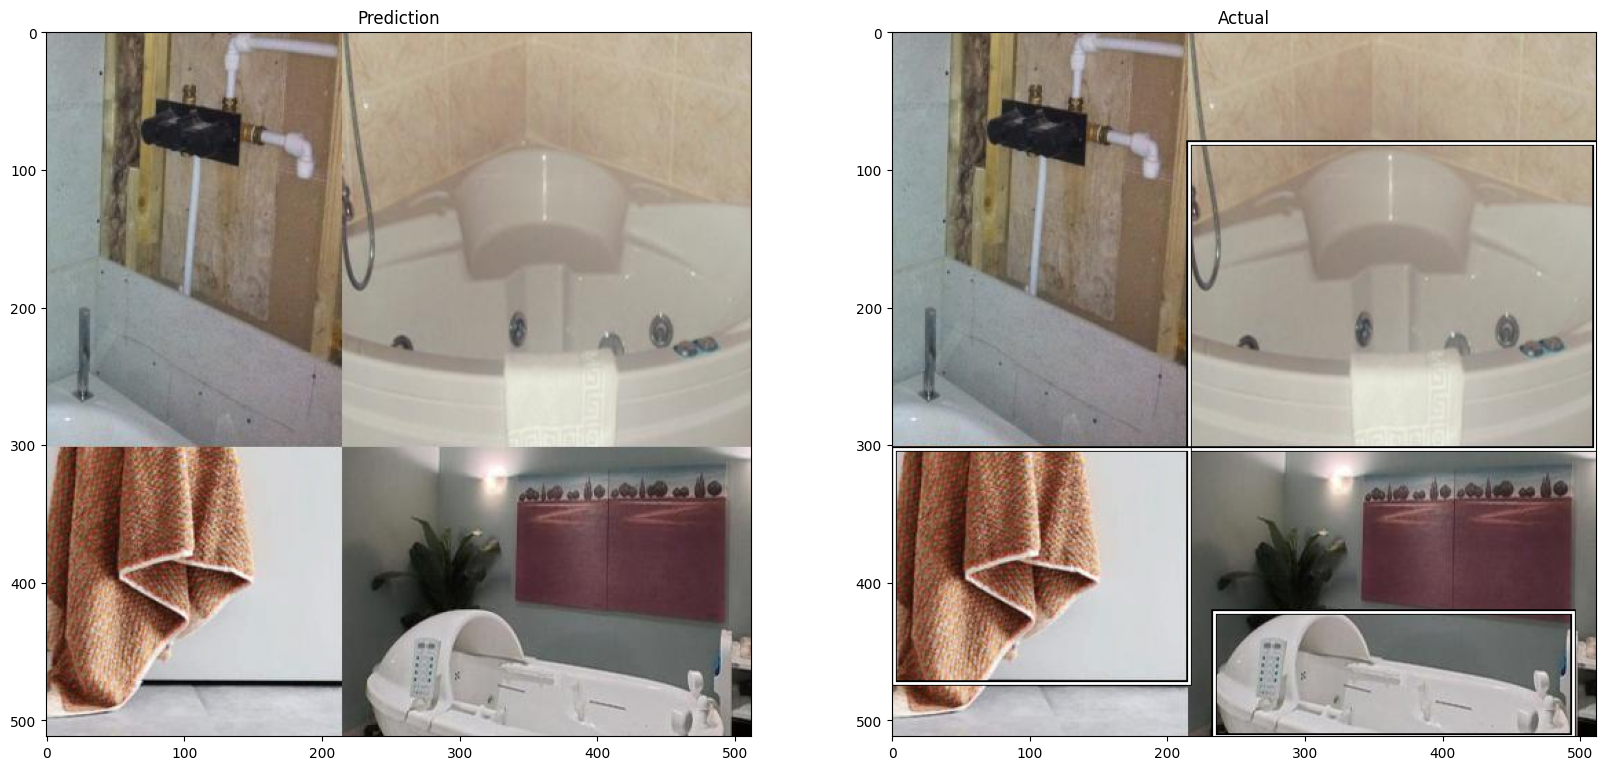

In [35]:
compare_bboxes_for_image(image1, predicted_bboxes=predicted_bboxes[0], actual_bboxes=truth_bboxes1.tolist())


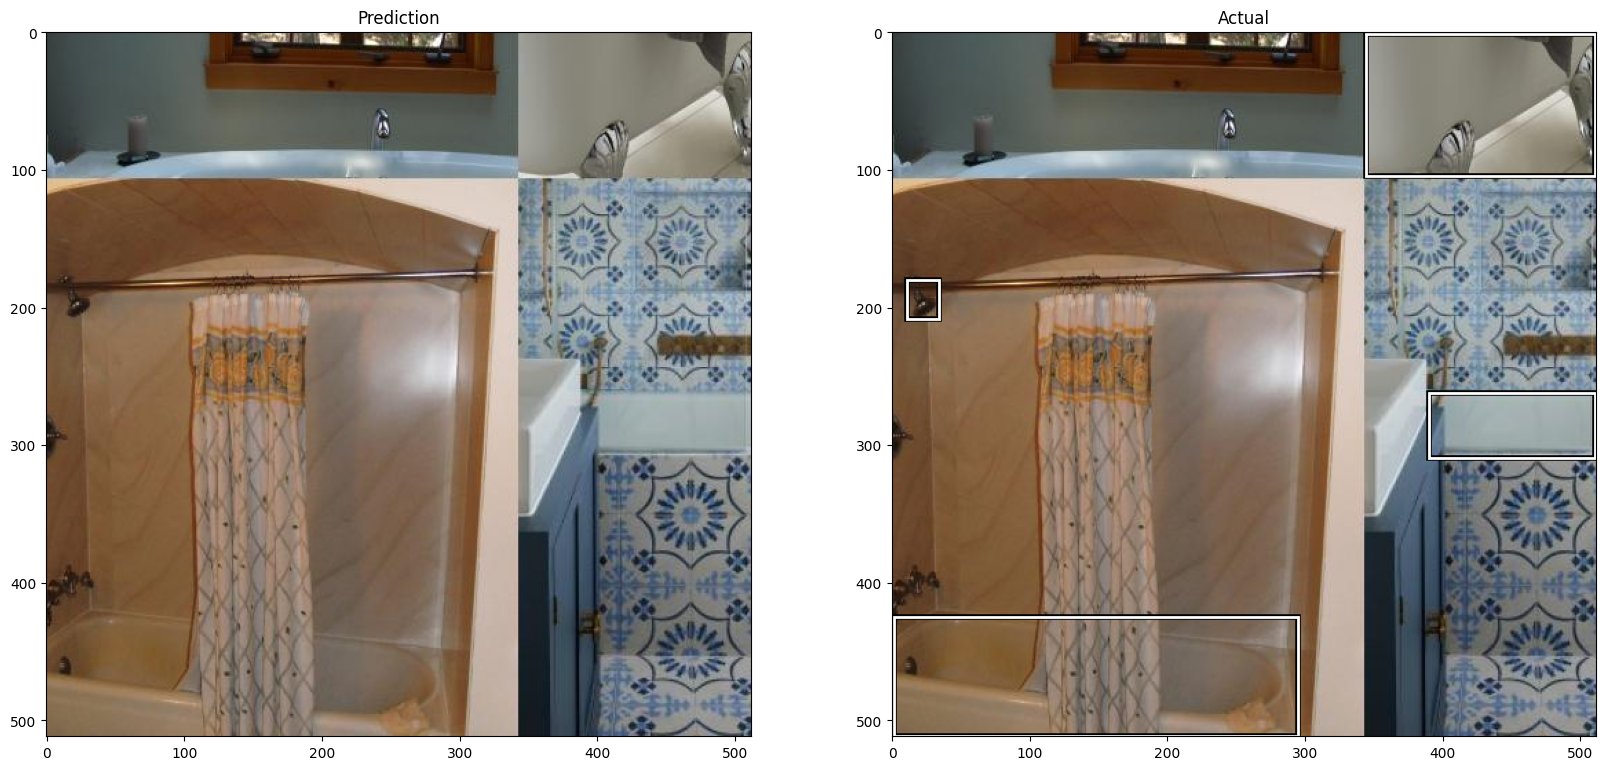

In [36]:
compare_bboxes_for_image(image2, predicted_bboxes=predicted_bboxes[1], actual_bboxes=truth_bboxes2.tolist())


In [37]:
#Using model hooks to manually debug
#One feature of PyTorch lightning is that it uses methods or 'hooks' to represent each part of the training process. Whilst we lose some visibility over our training loop when using the Trainer, we can use these hooks to easily debug each step.

#For example, we can use a hook defined on our DataModule to get the dataloader that will be used during validation and use this to grab a batch.

loader = dm.val_dataloader()
dl_iter = iter(loader)
batch = next(dl_iter)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


##Validation outputs and Coco metrics
We can use this batch to see exactly what the model calculated during validation. As lightning takes care of moving data to the correct device during training, for simplicity, we shall do this on the cpu so that we don't have to manually move all of the tensors in each batch to the device.

In [38]:
device = model.device; device

device(type='cpu')

In [39]:
output = model.validation_step(batch=batch, batch_idx=0)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/module.py:407: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


In [40]:
output

{'loss': tensor(5.3715),
 'batch_predictions': {'predictions': tensor([[[2.9107e+00, 4.9136e+02, 5.5653e+01, 5.1200e+02, 2.1531e-01,
            1.0000e+00],
           [0.0000e+00, 4.9962e+02, 0.0000e+00, 5.1200e+02, 2.0675e-01,
            4.0000e+00],
           [5.1200e+02, 0.0000e+00, 5.1200e+02, 1.8053e+02, 1.9409e-01,
            3.0000e+00],
           ...,
           [4.5414e+02, 4.6464e+02, 5.1200e+02, 5.1200e+02, 1.4839e-01,
            1.0000e+00],
           [5.1024e+02, 9.1160e+01, 5.1200e+02, 3.1466e+02, 1.4830e-01,
            3.0000e+00],
           [5.0332e+02, 4.6193e+02, 5.1200e+02, 4.9851e+02, 1.4820e-01,
            1.0000e+00]],
  
          [[4.9657e-01, 4.9080e+02, 4.9625e+01, 5.1200e+02, 2.2332e-01,
            1.0000e+00],
           [0.0000e+00, 4.9367e+02, 0.0000e+00, 5.1200e+02, 2.1420e-01,
            4.0000e+00],
           [4.7636e+02, 0.0000e+00, 5.1200e+02, 2.6740e+01, 2.0578e-01,
            3.0000e+00],
           ...,
           [4.8034e+02, 0.0000

Here, we can see that the loss is returned for the batch, as well as the predictions and targets.

In order to calculate metrics, for the epoch, we need to get the predictions corresponding to each batch. As the validation_step method will be called for each batch, let's define a function to aggregate the outputs.

Here, for simplicity, we will patch this function to the EfficientDet class using a convenience decorator from fastcore - we pay a huge performance price for Python being a dynamic language, we may as well make the most of it!

In [41]:
from fastcore.basics import patch

@patch
def aggregate_prediction_outputs(self: EfficientDetModel, outputs):

    detections = torch.cat(
        [output["batch_predictions"]["predictions"] for output in outputs]
    )

    image_ids = []
    targets = []
    for output in outputs:
        batch_predictions = output["batch_predictions"]
        image_ids.extend(batch_predictions["image_ids"])
        targets.extend(batch_predictions["targets"])

    (
        predicted_bboxes,
        predicted_class_confidences,
        predicted_class_labels,
    ) = self.post_process_detections(detections)

    return (
        predicted_class_labels,
        image_ids,
        predicted_bboxes,
        predicted_class_confidences,
        targets,
    )

From the PyTorch-lightning docs (see https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html#validation-epoch-level-metrics), we can see that we can add an additional hook `validation_epoch_end `which is called after all batches have been processed; at the end of each epoch, a list of step outputs are passed to this hook.

Let's use this hook to calculate the overall validation loss, as well as the COCO metrics using the `objdetecteval` package. we can use the output that we just calculated when evaluating a single validation batch, but this approach would also extend to the validation loop evaluation during training with lightning.

In [42]:
import locale
print(locale.getpreferredencoding())

ANSI_X3.4-1968


In [43]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [44]:
!pip install git+https://github.com/alexhock/object-detection-metrics

  Cloning https://github.com/alexhock/object-detection-metrics to /tmp/pip-req-build-2kv4hhwp
  Running command git clone --filter=blob:none --quiet https://github.com/alexhock/object-detection-metrics /tmp/pip-req-build-2kv4hhwp
  Resolved https://github.com/alexhock/object-detection-metrics to commit 4ba0cfa7677f8f0b65776567b6ccb7b45ac3b1e0
  Preparing metadata (setup.py) ... done
  Created wheel for objdetecteval: filename=objdetecteval-0.1-py3-none-any.whl size=12838 sha256=f4368d08d3711fe4ed8dcd8cce54c8250c58104bf421c09db4e6cc581b7b9678
  Stored in directory: /tmp/pip-ephem-wheel-cache-1a7kp_2y/wheels/89/91/66/9586ce1a87b2e7ff36e45bf531bf7f9490175eb83b8c3e8fc3
Successfully built objdetecteval


In [45]:
from objdetecteval.metrics.coco_metrics import get_coco_stats
@patch
def validation_epoch_end(self: EfficientDetModel, outputs):
    """Compute and log training loss and accuracy at the epoch level."""

    validation_loss_mean = torch.stack(
        [output["loss"] for output in outputs]
    ).mean()

    (
        predicted_class_labels,
        image_ids,
        predicted_bboxes,
        predicted_class_confidences,
        targets,
    ) = self.aggregate_prediction_outputs(outputs)

    truth_image_ids = [target["image_id"].detach().item() for target in targets]
    truth_boxes = [
        target["bboxes"].detach()[:, [1, 0, 3, 2]].tolist() for target in targets
    ] # convert to xyxy for evaluation
    truth_labels = [target["labels"].detach().tolist() for target in targets]

    stats = get_coco_stats(
        prediction_image_ids=image_ids,
        predicted_class_confidences=predicted_class_confidences,
        predicted_bboxes=predicted_bboxes,
        predicted_class_labels=predicted_class_labels,
        target_image_ids=truth_image_ids,
        target_bboxes=truth_boxes,
        target_class_labels=truth_labels,
    )['All']

    return {"val_loss": validation_loss_mean, "metrics": stats}
model.validation_epoch_end([output])

{'val_loss': tensor(5.3715),
 'metrics': {'AP_all': -1,
  'AP_all_IOU_0_50': -1,
  'AP_all_IOU_0_75': -1,
  'AP_small': -1,
  'AP_medium': -1,
  'AP_large': -1,
  'AR_all_dets_1': -1,
  'AR_all_dets_10': -1,
  'AR_all': -1,
  'AR_small': -1,
  'AR_medium': -1,
  'AR_large': -1}}

###For Inference

## We can also use the predict function directly on the processed images returned from our data loader. Let's now unpack the batch to just get the images, as we don't need the labels for inference.

In [46]:
images, annotations,targets, image_ids = batch

Thanks to the typedispatch decorator, we can use the same predict function signature on these tensors.

In [ ]:
predicted_bboxes, predicted_class_labels, predicted_class_confidences = model.predict(images)

It is important to note at this point that the images given by the dataloader have already been transformed and scaled to size 512. Therefore, the bounding boxes predicted will be relative for an image of 512. As such, to visualise these predictions on the original image, we must rescale it.

In [ ]:
image, _, _, _ = train_ds.get_image_and_labels_by_idx(0)

In [ ]:
show_image(image.resize((512, 512)), predicted_bboxes[0])

As we can see, after rescaling, the bounding box is in the correct position!